In [2]:
!pip install kaggle

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [4]:
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -d muhammadhananasghar/human-emotions-datasethes

 99% 305M/309M [00:05<00:00, 69.2MB/s]
100% 309M/309M [00:05<00:00, 62.7MB/s]


In [6]:
!unzip /content/human-emotions-datasethes.zip


  inflating: EmotionsDataset/data/nothing/860.jpg  
  inflating: EmotionsDataset/data/nothing/861.jpg  
  inflating: EmotionsDataset/data/nothing/862.jpg  
  inflating: EmotionsDataset/data/nothing/863.jpg  
  inflating: EmotionsDataset/data/nothing/864.jpg  
  inflating: EmotionsDataset/data/nothing/865.jpg  
  inflating: EmotionsDataset/data/nothing/866.jpg  
  inflating: EmotionsDataset/data/nothing/867.jpg  
  inflating: EmotionsDataset/data/nothing/868.jpg  
  inflating: EmotionsDataset/data/nothing/869.jpg  
  inflating: EmotionsDataset/data/nothing/87.jpg  
  inflating: EmotionsDataset/data/nothing/870.jpg  
  inflating: EmotionsDataset/data/nothing/871.jpg  
  inflating: EmotionsDataset/data/nothing/872.jpg  
  inflating: EmotionsDataset/data/nothing/873.jpg  
  inflating: EmotionsDataset/data/nothing/874.jpg  
  inflating: EmotionsDataset/data/nothing/875.jpg  
  inflating: EmotionsDataset/data/nothing/876.jpg  
  inflating: EmotionsDataset/data/nothing/877.jpg  
  inflating:

In [7]:
TRAIN_PATH = "/content/Emotions Dataset/Emotions Dataset/train"
VAL_PATH = "/content/Emotions Dataset/Emotions Dataset/test"

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense , InputLayer , Conv2D , MaxPool2D , BatchNormalization ,Flatten , Input , GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalFocalCrossentropy
from tensorflow.keras.regularizers import L2
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.metrics import Recall ,Precision , TruePositives
from tensorflow.keras.metrics import TrueNegatives ,FalsePositives ,FalseNegatives ,CategoricalAccuracy

In [9]:
CONFIG = {
    'CLASS_NAMES': ['angry','happy', 'sad'],
    'IMAGE_SIZE' : 256,
    'BATCH_SIZE' : 32 ,
    'MATREICS': [CategoricalAccuracy(name = 'Accuracy'),Precision(name = 'Precision') ,Recall(name = 'Recall'), TruePositives(name = 'TP') ,FalsePositives(name = 'FP'),TrueNegatives(name = 'TN') , FalseNegatives(name = 'FN')],
    'OPTIMIZER' : Adam(learning_rate =  1e-3),
    'LOSS' : CategoricalFocalCrossentropy(),
    'EPOCHS' : 20
}

In [8]:

train_dataset = image_dataset_from_directory(
    TRAIN_PATH,
    labels='inferred',
    label_mode='categorical',
    class_names=None,
    color_mode='rgb',
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
    seed=99,
)

Found 6799 files belonging to 3 classes.


In [10]:
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>

In [11]:
val_dataset = image_dataset_from_directory(
    VAL_PATH,
    labels='inferred',
    label_mode='categorical',
    class_names=None,
    color_mode='rgb',
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
    seed=99,
)

Found 2278 files belonging to 3 classes.


In [12]:
val_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>

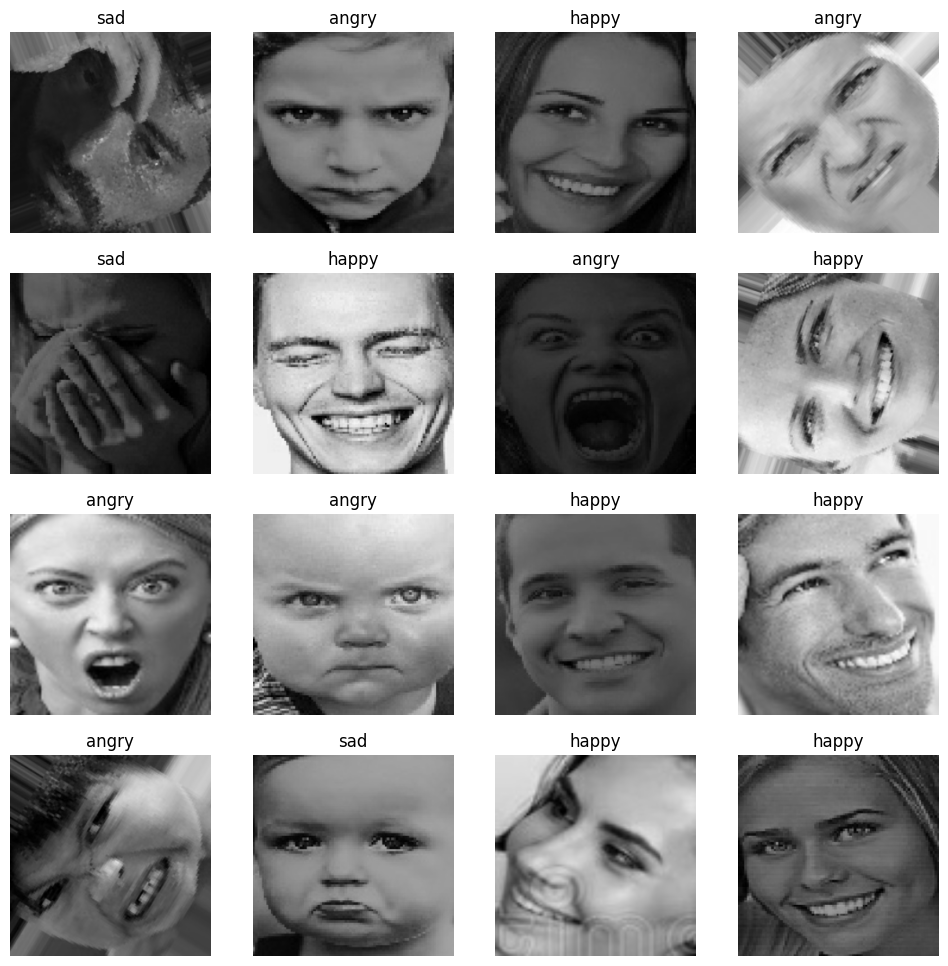

In [13]:
plt.figure(figsize = (12,12))

for images, labels in train_dataset.take(1):
  for i in range(16):
    ax = plt.subplot(4,4, i+1)
    plt.imshow(images[i]/255.)
    plt.title(CONFIG["CLASS_NAMES"][tf.argmax(labels[i], axis = 0).numpy()])
    plt.axis("off")

In [14]:
def augment_image(image, label):
    image = tf.image.convert_image_dtype(image, tf.float32)
    rotation_angle = tf.random.uniform(shape=[], minval=-50, maxval=50)
    image = tf.image.rot90(image, k=tf.cast(rotation_angle / 90, tf.int32))

    image = tf.image.random_flip_left_right(image)

    return image ,label

In [15]:
train_dataset = train_dataset.map(augment_image)

In [41]:
train_dataset

<_MapDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>

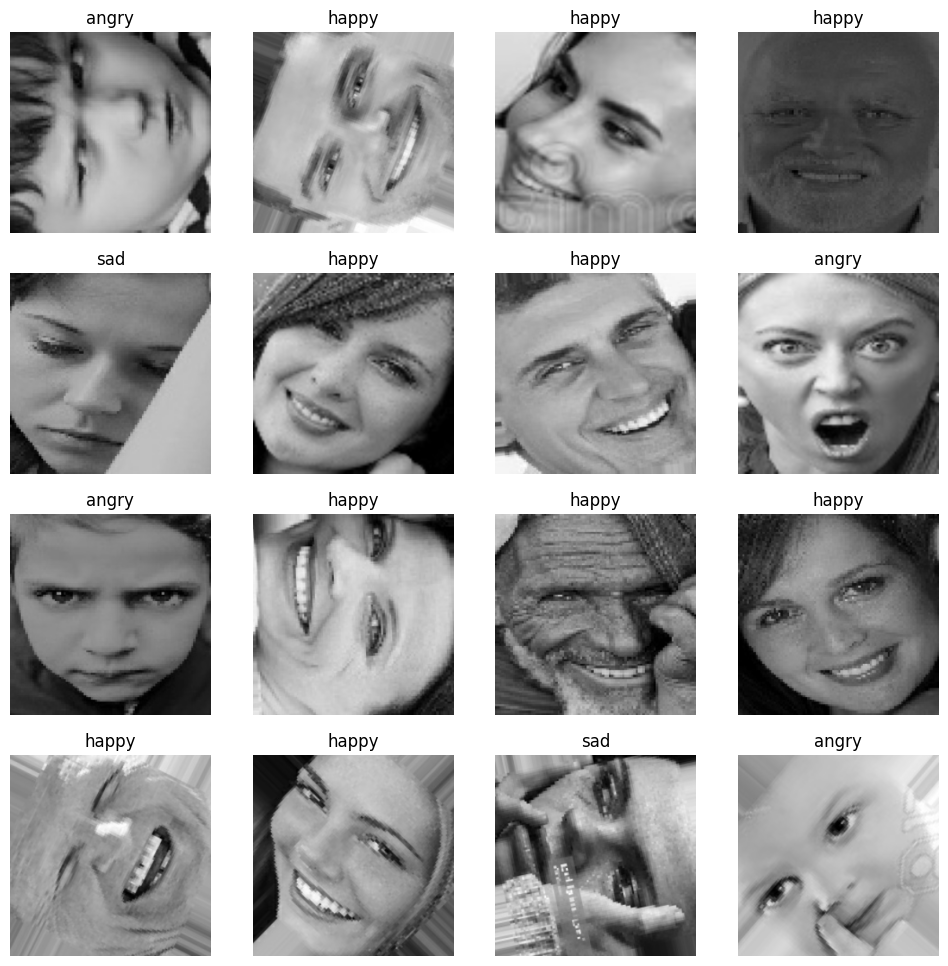

In [16]:
plt.figure(figsize = (12,12))

for images, labels in train_dataset.take(1):
  for i in range(16):
    ax = plt.subplot(4,4, i+1)
    plt.imshow(images[i]/255.)
    plt.title(CONFIG["CLASS_NAMES"][tf.argmax(labels[i], axis = 0).numpy()])
    plt.axis("off")

In [17]:
train_dataset = train_dataset.shuffle(buffer_size = 8 ,reshuffle_each_iteration=True).prefetch(tf.data.AUTOTUNE)

In [18]:
train_dataset.take(1)

<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>

In [19]:
val_dataset = val_dataset.shuffle(buffer_size = 8 ,reshuffle_each_iteration=True).prefetch(tf.data.AUTOTUNE)

In [20]:
backbone = tf.keras.applications.efficientnet.EfficientNetB4(
    include_top = False,
    weights='imagenet',
    input_shape=(CONFIG["IMAGE_SIZE"], CONFIG["IMAGE_SIZE"], 3),
    )

71686520/71686520 [==============================] - 0s 0us/step


In [22]:
pretrained_model = tf.keras.Sequential([
    Input(shape = (CONFIG["IMAGE_SIZE"] ,CONFIG["IMAGE_SIZE"],3)),
    backbone,
    GlobalAveragePooling2D(),
    Dense( 1024, activation = "relu"),
    BatchNormalization(),
    Dense( 128, activation = "relu"),
    Dense( 3, activation = "softmax"),

    ])

In [23]:
backbone.trainable = False

In [24]:
pretrained_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb4 (Functional  (None, 8, 8, 1792)        17673823  
 )                                                               
                                                                 
 global_average_pooling2d_1  (None, 1792)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_3 (Dense)             (None, 1024)              1836032   
                                                                 
 batch_normalization_1 (Bat  (None, 1024)              4096      
 chNormalization)                                                
                                                                 
 dense_4 (Dense)             (None, 128)               131200    
                                                      

In [25]:
pretrained_model.compile(
    optimizer = CONFIG['OPTIMIZER'],
    metrics = CONFIG['MATREICS'],
    loss = CONFIG['LOSS']
)

In [26]:
history = pretrained_model.fit(train_dataset , validation_data=val_dataset , epochs= CONFIG['EPOCHS'], verbose = 1)

Epoch 1/20
213/213 [==============================] - 84s 303ms/step - loss: 0.1244 - Accuracy: 0.6580 - Precision: 0.6959 - Recall: 0.6061 - TP: 4121.0000 - FP: 1801.0000 - TN: 11797.0000 - FN: 2678.0000 - val_loss: 0.0849 - val_Accuracy: 0.6853 - val_Precision: 0.7493 - val_Recall: 0.5878 - val_TP: 1339.0000 - val_FP: 448.0000 - val_TN: 4108.0000 - val_FN: 939.0000
Epoch 2/20
213/213 [==============================] - 63s 293ms/step - loss: 0.0671 - Accuracy: 0.7398 - Precision: 0.7953 - Recall: 0.6604 - TP: 4490.0000 - FP: 1156.0000 - TN: 12442.0000 - FN: 2309.0000 - val_loss: 0.0694 - val_Accuracy: 0.7533 - val_Precision: 0.8153 - val_Recall: 0.6743 - val_TP: 1536.0000 - val_FP: 348.0000 - val_TN: 4208.0000 - val_FN: 742.0000
Epoch 3/20
213/213 [==============================] - 56s 259ms/step - loss: 0.0524 - Accuracy: 0.7844 - Precision: 0.8412 - Recall: 0.7060 - TP: 4800.0000 - FP: 906.0000 - TN: 12692.0000 - FN: 1999.0000 - val_loss: 0.0683 - val_Accuracy: 0.7638 - val_Precisio

In [37]:
h = pretrained_model.evaluate(val_dataset)

72/72 [==============================] - 15s 182ms/step - loss: 0.0671 - Accuracy: 0.8060 - Precision: 0.8284 - Recall: 0.7796 - TP: 1776.0000 - FP: 368.0000 - TN: 4188.0000 - FN: 502.0000


In [38]:
h

[0.06714558601379395,
 0.8059701323509216,
 0.8283582329750061,
 0.7796312570571899,
 1776.0,
 368.0,
 4188.0,
 502.0]

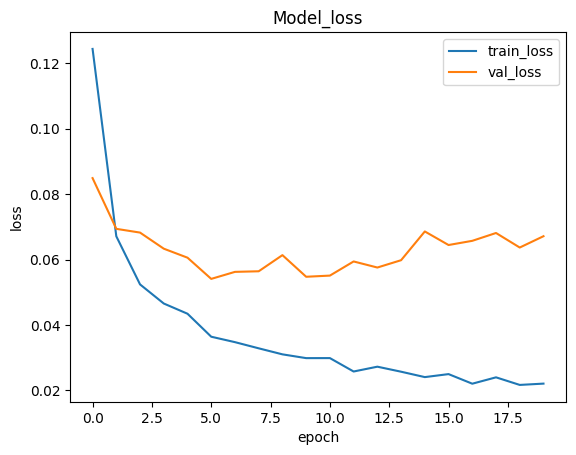

In [28]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

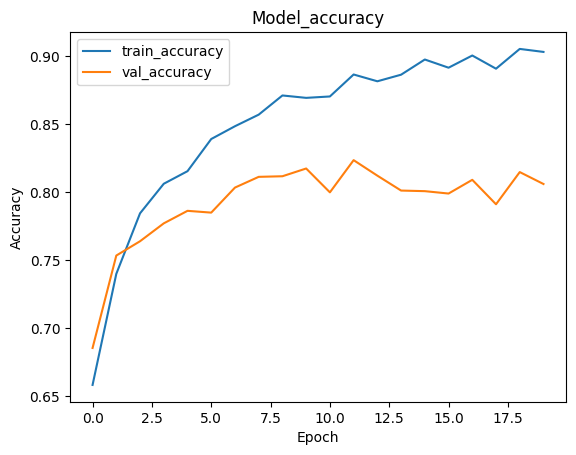

In [29]:
plt.plot(history.history['Accuracy'])
plt.plot(history.history['val_Accuracy'])
plt.title('Model_accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train_accuracy', 'val_accuracy'])
plt.show()

1/1 [==============================] - 0s 42ms/step


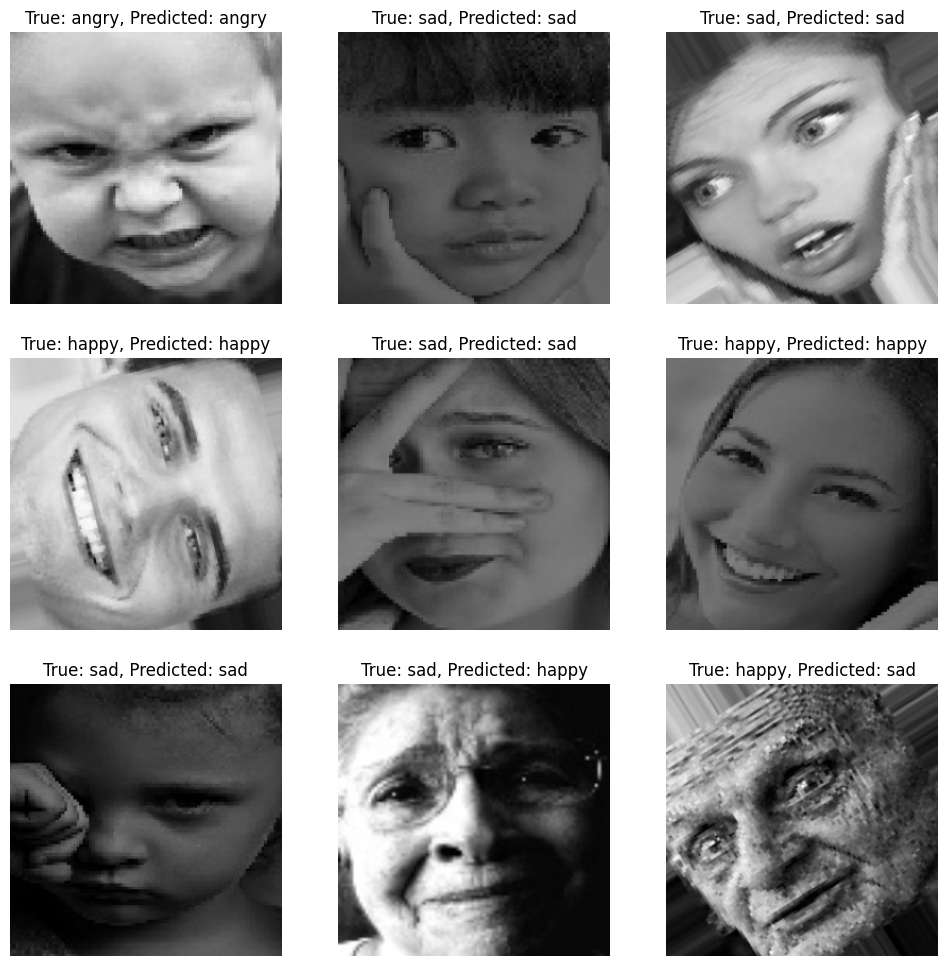

In [35]:
plt.figure(figsize = (12,12))
for i, (image, label) in enumerate(val_dataset.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image[0]/255.)
    predicted_label = tf.argmax(pretrained_model.predict(image), axis=1).numpy()[0]
    true_label = tf.argmax(label, axis=1).numpy()[0]
    plt.title(f"True: {CONFIG['CLASS_NAMES'][true_label]}, Predicted: {CONFIG['CLASS_NAMES'][predicted_label]}")
    plt.axis('off')
plt.show()


In [41]:
## loss: 0.0671 - Accuracy: 0.8060 - Precision: 0.8284 - Recall: 0.7796 - TP: 1776.0000 - FP: 368.0000 - TN: 4188.0000 - FN: 502.0000
h

[0.06714558601379395,
 0.8059701323509216,
 0.8283582329750061,
 0.7796312570571899,
 1776.0,
 368.0,
 4188.0,
 502.0]

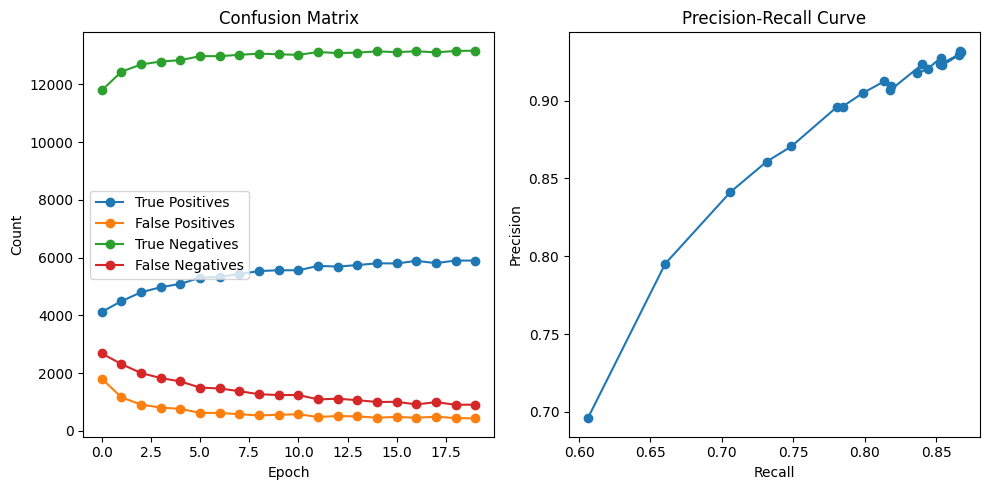

In [43]:
TP = history.history['TP']
FP = history.history['FP']
TN = history.history['TN']
FN = history.history['FN']

# Calculate precision and recall
precision = history.history['Precision']
recall = history.history['Recall']

# Plot confusion matrix
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(np.arange(len(TP)), TP, label='True Positives', marker='o')
plt.plot(np.arange(len(FP)), FP, label='False Positives', marker='o')
plt.plot(np.arange(len(TN)), TN, label='True Negatives', marker='o')
plt.plot(np.arange(len(FN)), FN, label='False Negatives', marker='o')
plt.title('Confusion Matrix')
plt.xlabel('Epoch')
plt.ylabel('Count')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(recall, precision, marker='o')
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')

plt.tight_layout()
plt.show()
